# Diabetic Retinopathy Detection – Phase 2: Exploratory Data Analysis (EDA)

### 🎯 **Objective**
The goal of this notebook is to conduct a thorough exploratory data analysis of our curated dataset. We will use the `clean_metadata.csv` file generated in Phase 1 as our starting point. The primary objectives are:

1.  **Visualize the Data:** To look at sample images from each diagnostic class to gain a qualitative understanding of the features the model will need to learn.
2.  **Confirm Dataset Characteristics:** To re-examine the class distribution of our final, clean dataset.
3.  **Inform Modeling Strategy:** To derive insights from the data that will guide our approach in the subsequent modeling phase.

---

### 🧾 **Business Rationale (Senior BA Perspective)**
Having established a trusted dataset in Phase 1, we now move to asset exploration. From a business perspective, this EDA phase is about understanding the nuances of our core asset—the data. By visualizing the images associated with each stage of Diabetic Retinopathy, we build intuition about the problem's complexity.

This analysis allows us to answer critical questions:
- How subtle are the differences between "Mild" and "Moderate" DR?
- Are there visible quality issues in the images themselves?

The findings from this phase are essential for setting realistic expectations for model performance and for communicating the nature of the data to both technical and non-technical stakeholders. This step ensures our modeling strategy is data-driven, not based on assumptions.

In [1]:
# Import necessary libraries and cleaned metadata
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # OpenCV for image loading

# Define the path to our clean metadata file
METADATA_PATH = "Data/aptos2019-blindness-detection/clean_metadata.csv"

# Load the data
try:
    df = pd.read_csv(METADATA_PATH)
    print(f"✅ Successfully loaded clean metadata from: {METADATA_PATH}")
    print(f"Dataset contains {len(df)} verified images.")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find the metadata file at {METADATA_PATH}")
    print("Please ensure you have successfully run the '01_preprocess.py' script first.")
    df = pd.DataFrame() # Create an empty dataframe to prevent errors

if not df.empty:
    print("\nSample of the loaded clean metadata:")
    print(df.head())

✅ Successfully loaded clean metadata from: Data/aptos2019-blindness-detection/clean_metadata.csv
Dataset contains 3534 verified images.

Sample of the loaded clean metadata:
        id_code  diagnosis                                           filepath  \
0  000c1434d8d7          2  .\Data/aptos2019-blindness-detection/train_ima...   
1  001639a390f0          4  .\Data/aptos2019-blindness-detection/train_ima...   
2  0024cdab0c1e          1  .\Data/aptos2019-blindness-detection/train_ima...   
3  002c21358ce6          0  .\Data/aptos2019-blindness-detection/train_ima...   
4  005b95c28852          0  .\Data/aptos2019-blindness-detection/train_ima...   

    diagnosis_label  
0          Moderate  
1  Proliferative DR  
2              Mild  
3             No DR  
4             No DR  


### Analyze Final Class Distribution

Now, we will visualize the class distribution of our **final, clean dataset**. This confirms the exact number of images per class that will be used for training and helps solidify our strategy for handling the class imbalance.

Final Class Distribution on Cleaned Data (Correctly Ordered):
diagnosis_label
No DR               1798
Mild                 341
Moderate             934
Severe               182
Proliferative DR     279
Name: count, dtype: int64


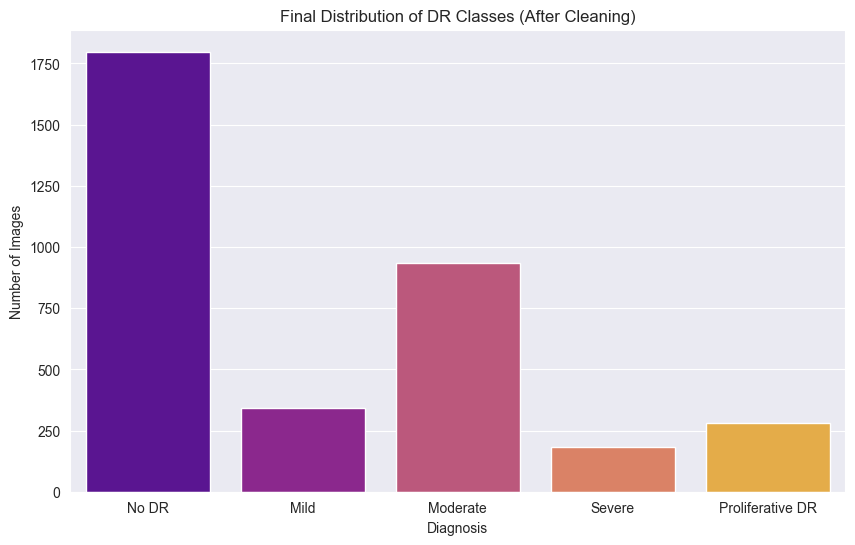

In [3]:
if not df.empty:
    # Define the correct clinical order for the labels
    diagnosis_order = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

    # Convert the 'diagnosis_label' column to a categorical type. This forces
    # pandas and seaborn to respect our specified order.
    df['diagnosis_label'] = pd.Categorical(df['diagnosis_label'], categories=diagnosis_order, ordered=True)

    # Now, value_counts() followed by sort_index() will use the correct clinical order
    class_counts = df['diagnosis_label'].value_counts().sort_index()

    print("Final Class Distribution on Cleaned Data (Correctly Ordered):")
    print(class_counts)

    # Visualize
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=class_counts.index,
        y=class_counts.values,
        hue=class_counts.index,
        palette="plasma",
        legend=False
    )
    plt.title('Final Distribution of DR Classes (After Cleaning)')
    plt.xlabel('Diagnosis')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=0) # Set rotation to 0 for better readability
    plt.show()


### Step 3: Visualize Sample Images from Each Class

Now that we understand the *quantity* of data in each class, let's examine the *quality*. By viewing sample images from each category, we can gain a crucial, qualitative understanding of the visual features and the difficulty of the classification task.

Rationale: This visual audit is critical. It helps us, as analysts, to understand the problem domain better and to spot any potential issues with the images (e.g., poor lighting, artifacts) that might affect the model. For stakeholders, it provides a tangible look at the data we are working with.

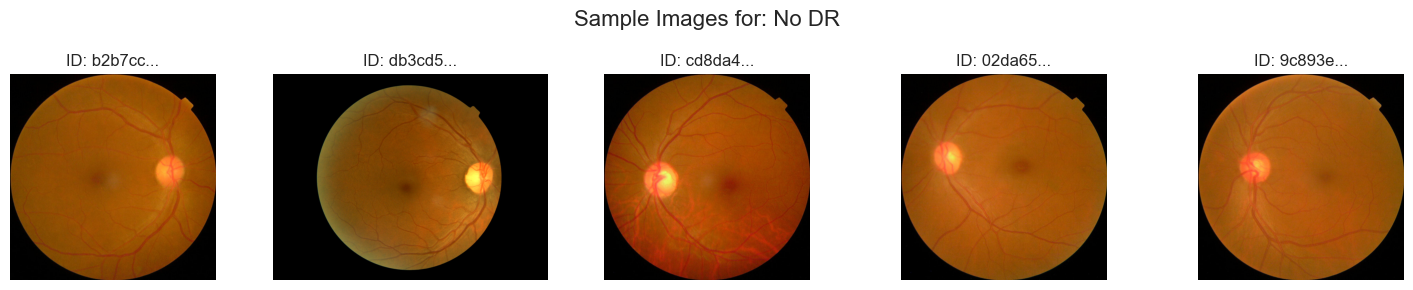

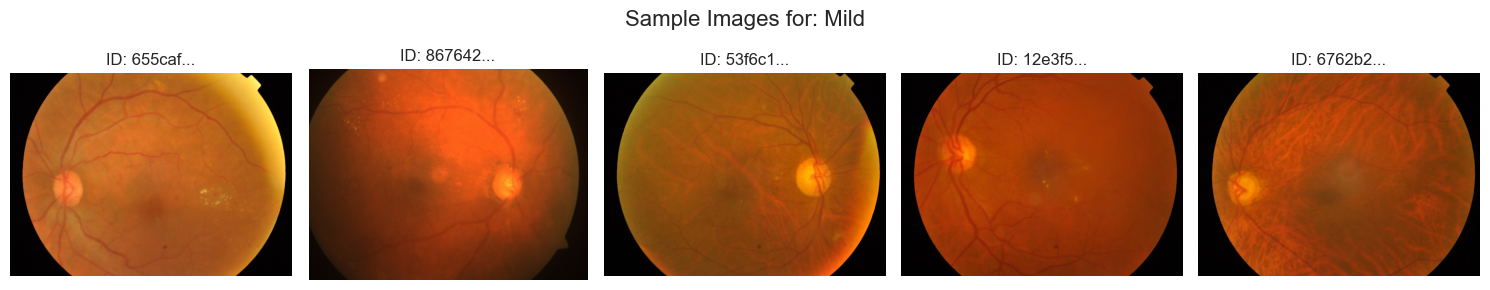

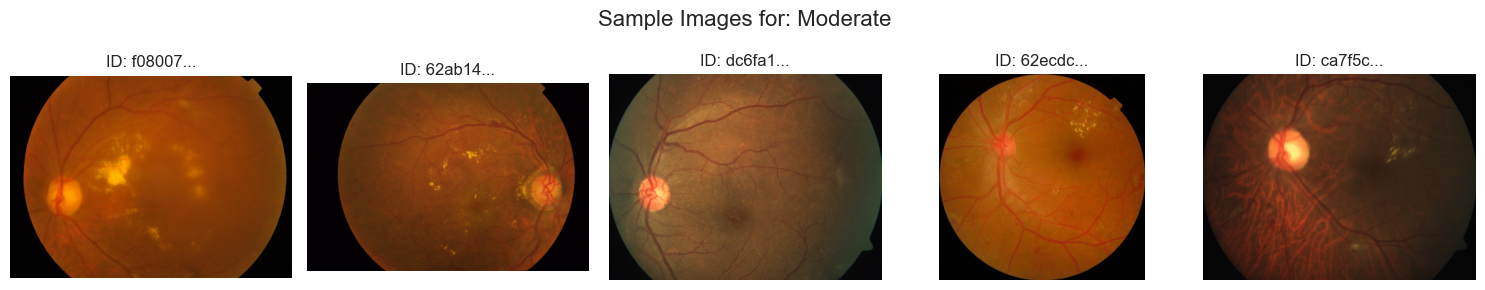

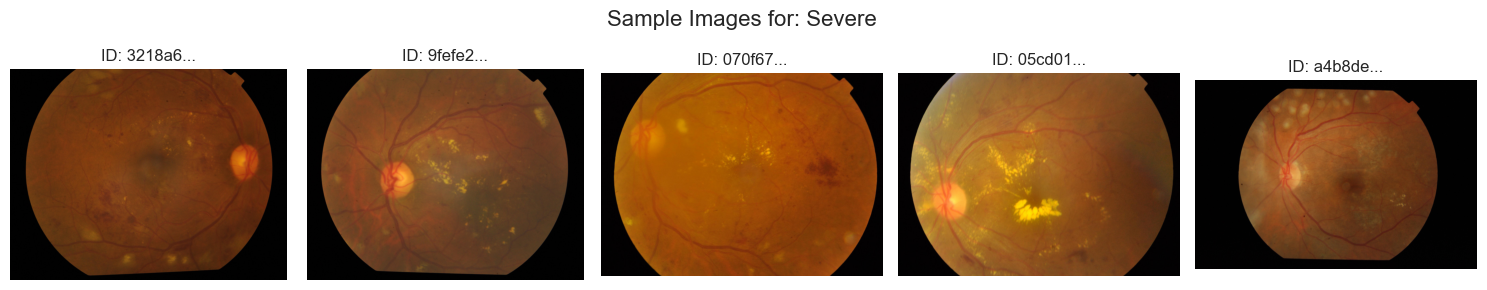

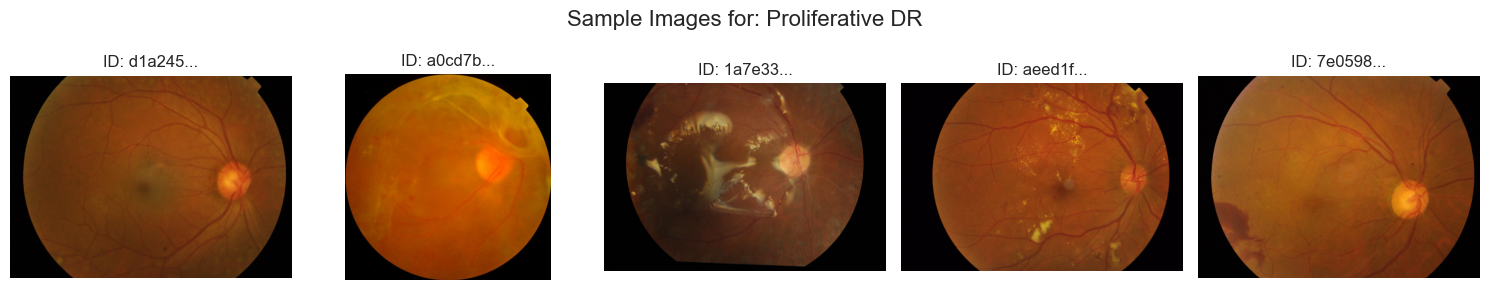

In [4]:
def display_samples(df, diagnosis_label, num_samples=5):
    """
    Displays a grid of random sample images for a given diagnosis label.
    """
    # Filter the dataframe for the specific diagnosis
    sample_df = df[df['diagnosis_label'] == diagnosis_label].sample(num_samples)

    # Create a plot
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle(f"Sample Images for: {diagnosis_label}", fontsize=16)

    for i, (index, row) in enumerate(sample_df.iterrows()):
        # Load the image using the filepath
        img = cv2.imread(row['filepath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert for matplotlib

        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(f"ID: {row['id_code'][:6]}...")
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if not df.empty:
    # Loop through our ordered list of diagnoses and display samples for each
    for diagnosis in diagnosis_order:
        display_samples(df, diagnosis)

### Step 4: EDA Conclusion and Implications for Modeling

This exploratory data analysis phase has yielded several critical insights that will directly inform our strategy for the upcoming modeling phase.

#### **Key Findings:**
1.  **Significant Class Imbalance:** The dataset is heavily skewed towards the 'No DR' class, which accounts for over 50% of the data. The 'Severe' and 'Proliferative' classes are severely underrepresented.
2.  **Subtle Inter-Class Differences:** Our visual inspection reveals that while the difference between 'No DR' and 'Severe DR' is visually obvious, the distinction between adjacent classes (e.g., 'Mild' vs. 'Moderate') is much more subtle, relying on the identification of small features like microaneurysms and hemorrhages.
3.  **High Data Quality:** The images in our cleaned dataset are generally of high quality, with consistent lighting and focus, thanks to the verification and curation steps in Phase 1.

#### **Actionable Implications for Phase 3 (Modeling):**
* **Stratified Splitting is Mandatory:** When creating training and validation sets, we must use stratification to ensure the class distributions are preserved in both splits.
* **Advanced Models are Required:** The subtlety of the features necessitates the use of a powerful, pre-trained model. **Transfer Learning** with an architecture like `EfficientNet` or `ResNet` will be our primary strategy, as a simple CNN built from scratch would likely fail to learn these complex patterns.
* **Class Weighting is Essential:** To combat the class imbalance during training, we must use a class weighting strategy to penalize the model more for misclassifying the minority classes.
* **Data Augmentation is a Priority:** We will need to apply aggressive data augmentation (rotation, zooming, brightness/contrast adjustments) to the training data. This will help the model generalize better and artificially increase the number of samples for the underrepresented classes.

This EDA phase is now complete. We have a solid, data-driven plan for how to approach the modeling challenge.
